# Overfitting and Regularization

## Imports

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [78]:
set_config(display='diagram')

## Settings

In [79]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [80]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

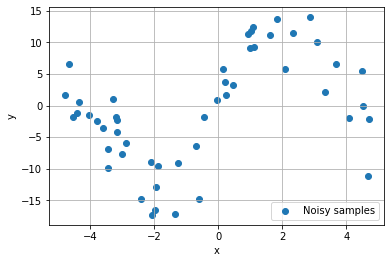

In [81]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

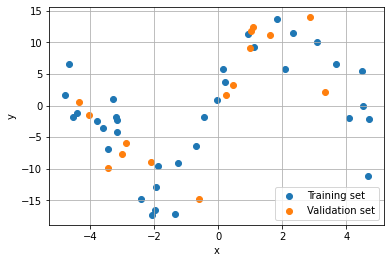

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [83]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [84]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

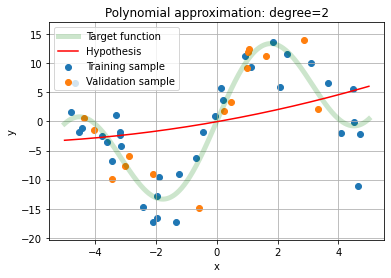

In [85]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

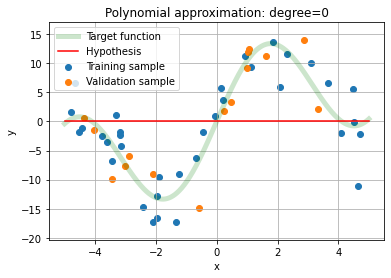

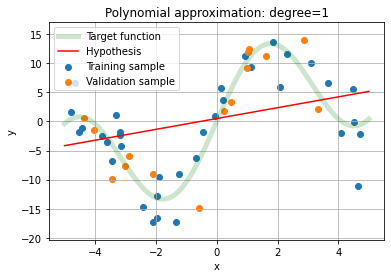

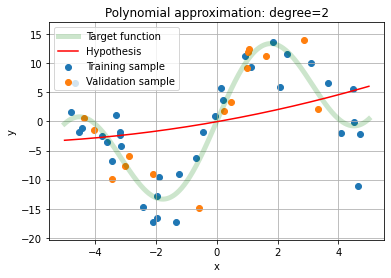

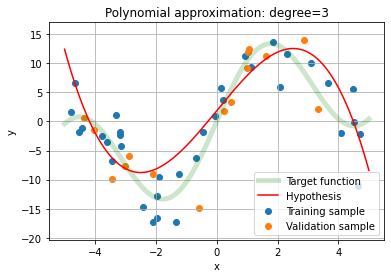

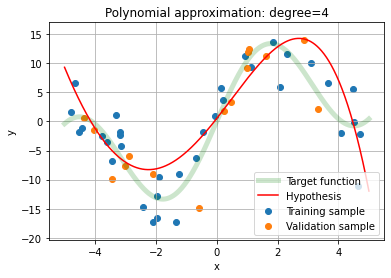

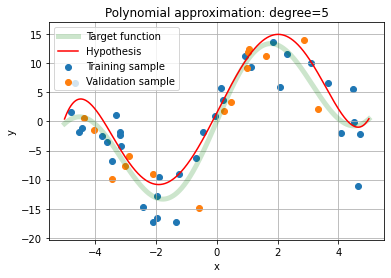

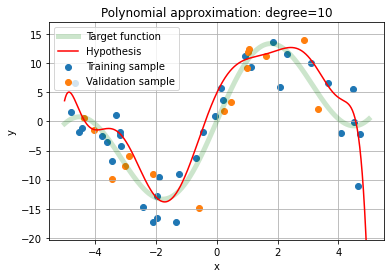

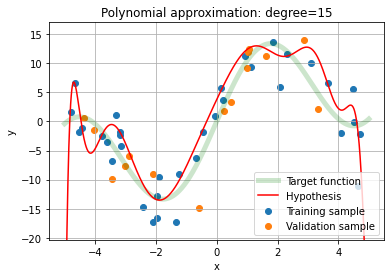

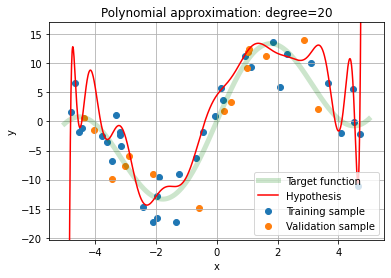

In [86]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

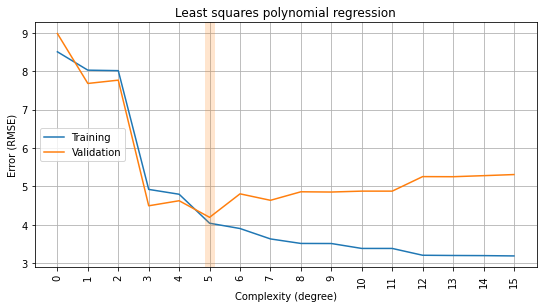

In [87]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [88]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

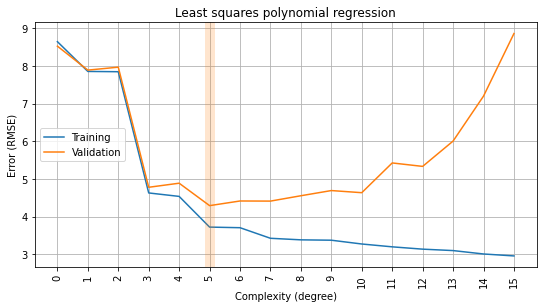

In [89]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [90]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

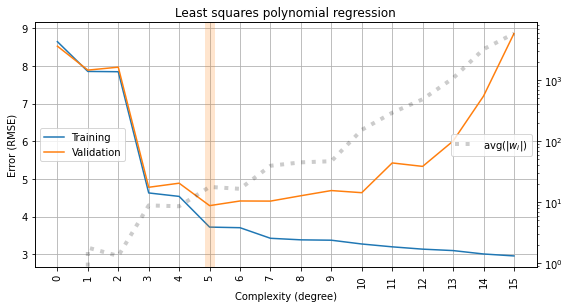

In [91]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

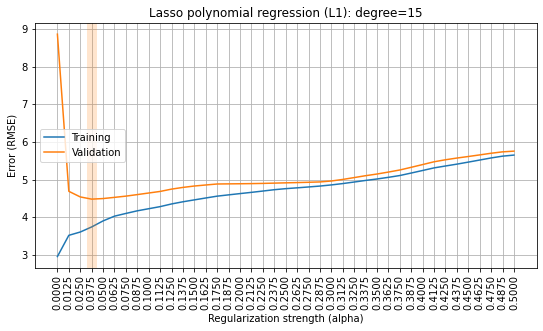

In [92]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

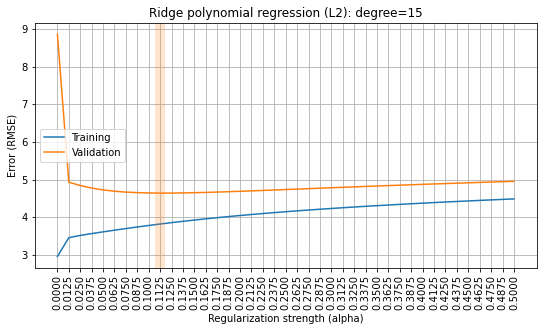

In [93]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

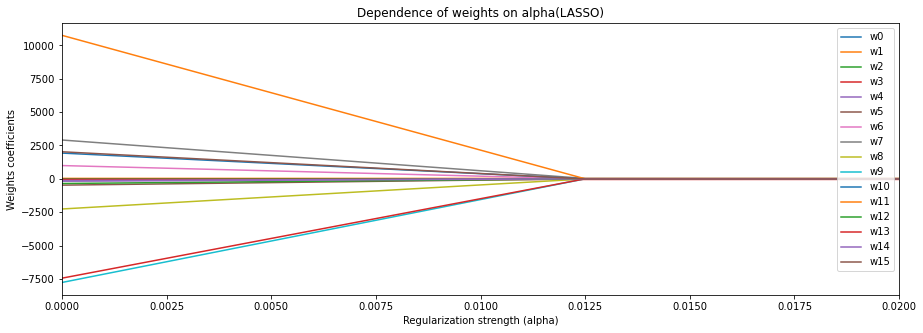

In [94]:
## your code
columns = ['w'+str(i) for i in range(0, degree+1)]
weights = []
for alpha in ALPHAS:
    weights.append(list(make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)['reg'].coef_))
L1_weights = pd.DataFrame(weights, columns=columns)
plt.figure(figsize=(15, 5))
plt.title('Dependence of weights on alpha(LASSO)')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Weights coefficients')
for column in columns:
    plt.plot(ALPHAS, L1_weights[column], label=column)
plt.legend(loc='upper right')
plt.xlim(0, 0.02)
plt.show()

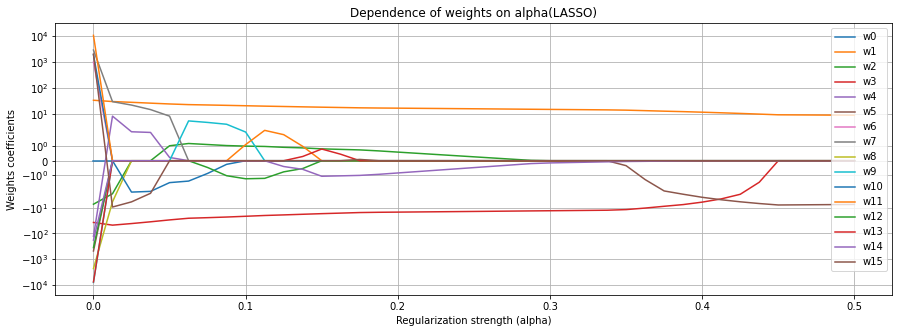

In [95]:
plt.figure(figsize=(15, 5))
for column in columns:
    plt.plot(ALPHAS, L1_weights[column], label=column)
plt.yscale('symlog')
plt.title('Dependence of weights on alpha(LASSO)')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Weights coefficients')
plt.grid(True)
plt.legend(loc='upper right')

In [96]:
import plotly.graph_objects as go

fig = go.Figure()

config = dict({'scrollZoom': True})

for column in columns:
    fig.add_trace(
    go.Scatter(
        x=ALPHAS,
        y=L1_weights[column], name=column))

fig.update_layout(
    legend=dict(
        title='Dependence of weights on alpha(LASSO)', orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
    )
)

fig.update_xaxes(title='Regularization strength (alpha)')
fig.update_yaxes(title='Weights coefficients')

fig.show(config=config)

#### L2

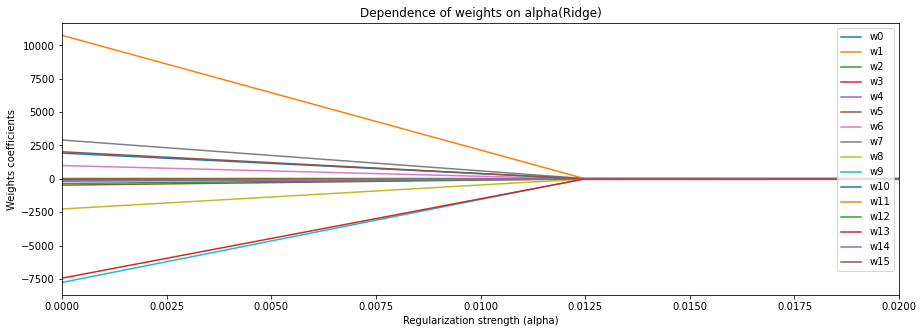

In [97]:
## your code
columns = ['w'+str(i) for i in range(0, degree+1)]
weights = []
for alpha in ALPHAS:
    weights.append(list(make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)['reg'].coef_))
L2_weights = pd.DataFrame(weights, columns=columns)
plt.figure(figsize=(15, 5))
plt.title('Dependence of weights on alpha(Ridge)')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Weights coefficients')
for column in columns:
    plt.plot(ALPHAS, L2_weights[column], label=column)
plt.legend(loc='upper right')
plt.xlim(0, 0.02)
plt.show()

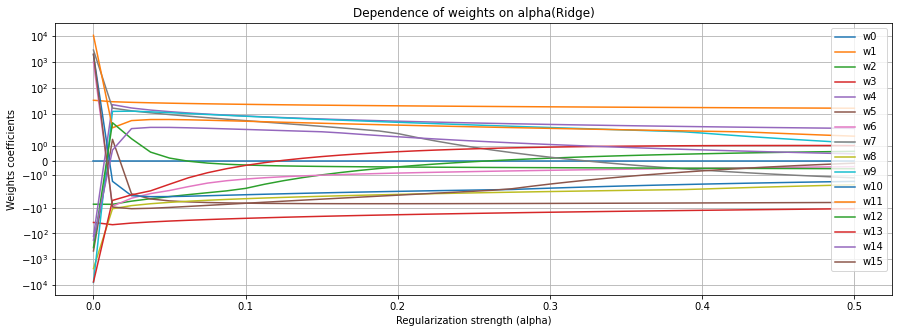

In [98]:
plt.figure(figsize=(15, 5))
for column in columns:
    plt.plot(ALPHAS, L2_weights[column], label=column)
plt.yscale('symlog')
plt.title('Dependence of weights on alpha(Ridge)')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Weights coefficients')
plt.grid(True)
plt.legend(loc='upper right')

In [99]:
fig = go.Figure()

config = dict({'scrollZoom': True})

for column in columns:
    fig.add_trace(
    go.Scatter(
        x=ALPHAS,
        y=L2_weights[column], name=column))

fig.update_layout(
    legend=dict(
        title='Dependence of weights on alpha(Ridge)', orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
    )
)

fig.update_xaxes(title='Regularization strength (alpha)')
fig.update_yaxes(title='Weights coefficients')
    
fig.show(config=config)

#### Summary

Both plots indicate that for $\alpha > 0.125$ weight coefficients approach zero. There maximum values are reached when $\alpha = 0$, so in this case it can be said that $|w_i(\alpha_j)| \leq w_i(\alpha_0)$.
More precise mathematical proof I came up with:\\
Error function for Ridge Regression
$$L_{Ridge}(w; λ) = \sum \limits_{i=1} ^{n} (y_i - x_i*w)^2 + \lambda \sum \limits_{j=1} ^{p}w_j^2$$
Minimum value of this function should be found to discover weights. To minimize this fuction means to minimize values of it's components. The minimum of the sum-of-squares is Mean Squared Error, which we already know. We can't find minimum value for second component, because minimum value for $\sum \limits_{j=1} ^{p}w_j^2$ would be 0, but this value does not apply because a regression model with zero coefficients vector does not make any sense. Supposing that $\lambda \rightarrow \inf$, $\sum \limits_{j=1} ^{p}w_j^2 \rightarrow 0$. That means that there is such a certain large number $C \in R$, for which $\sum \limits_{j=1} ^{p}w_j^2 \leq C$. It can be concluded that Ridge regression method does constraint the weights. For Lasso regression method the proof is similar.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [100]:
## your code
L1_weights

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15
0,0.0,33.544287,-7.399158,-37.434008,-127.812952,-473.619689,994.290665,2910.252779,-2261.136284,-7770.357341,1930.663785,10759.220095,-350.338737,-7447.970640,-179.921029,2028.803972
1,0.0,29.884555,-2.917159,-47.583442,8.176581,0.000000,-0.000000,29.593734,-5.982205,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-9.507557
2,0.0,27.920251,-0.000000,-41.335204,2.033817,0.000000,-0.000000,21.833312,-0.000000,0.000000,-2.518786,0.000000,-0.000000,-0.000000,-0.000000,-6.004842
3,0.0,25.915077,0.000000,-35.348023,1.966984,0.000000,-0.000000,14.622563,-0.000000,0.000000,-2.362843,0.000000,-0.000000,-0.000000,-0.000000,-2.801862
4,0.0,24.106128,1.040421,-29.882758,0.228452,0.000000,-0.000000,8.161169,-0.000000,0.000000,-1.521764,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
5,0.0,22.738773,1.197550,-25.758135,0.000000,0.000000,-0.000000,0.000000,-0.000000,5.337930,-1.414749,0.000000,-0.000000,0.000000,-0.000000,-0.000000
6,0.0,22.042686,1.126201,-24.477391,0.000000,0.000000,-0.000000,0.000000,-0.000000,4.666831,-0.882087,0.000000,-0.470711,0.000000,-0.000000,0.000000
7,0.0,21.318568,1.054269,-23.144374,0.000000,0.000000,-0.000000,0.000000,-0.000000,3.967103,-0.250272,0.000000,-1.042418,0.000000,-0.000000,0.000000
8,0.0,20.577653,1.015904,-21.627403,0.000000,-0.000000,-0.000000,0.000000,-0.000000,1.993215,-0.000000,1.123038,-1.253842,0.000000,-0.000000,0.000000
9,0.0,19.858808,0.992845,-20.163032,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,2.305357,-1.225157,0.000000,-0.000000,0.000000


#### L2

In [101]:
## your code
L2_weights

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15
0,0.0,33.544287,-7.399158,-37.434008,-127.812952,-473.619689,994.290665,2910.252779,-2261.136284,-7770.357341,1930.663785,10759.220095,-350.338737,-7447.970640,-179.921029,2028.803972
1,0.0,29.420854,-7.450420,-45.753656,22.653026,1.486257,-8.820215,16.702241,-11.062981,12.458043,-1.431452,2.896187,4.538058,-5.273732,0.741246,-9.524097
2,0.0,27.854604,-5.632728,-39.597585,16.856605,-2.948204,-4.335745,13.100540,-8.387751,12.711778,-3.468944,5.497024,1.529675,-3.222926,2.694749,-11.022734
3,0.0,26.741795,-4.542378,-35.870171,14.016723,-4.632528,-2.874597,10.964403,-7.094752,11.977063,-3.780723,6.036111,0.599857,-2.253747,3.005546,-10.616109
4,0.0,25.840792,-3.756891,-33.085153,12.171065,-5.504426,-2.184979,9.390039,-6.266714,11.097785,-3.750880,6.053807,0.184261,-1.632420,2.995283,-9.834870
5,0.0,25.077235,-3.149344,-30.839859,10.826428,-6.026232,-1.797335,8.136971,-5.668800,10.243878,-3.626713,5.895054,-0.035552,-1.181551,2.894009,-8.999366
6,0.0,24.414260,-2.660882,-28.959690,9.784653,-6.364669,-1.554491,7.101223,-5.206857,9.457104,-3.477437,5.672995,-0.164041,-0.833052,2.765337,-8.200557
7,0.0,23.829213,-2.258227,-27.348286,8.945792,-6.594775,-1.390039,6.225335,-4.834051,8.744422,-3.326489,5.432012,-0.244524,-0.553494,2.630979,-7.464810
8,0.0,23.306593,-1.920326,-25.944677,8.252105,-6.755441,-1.271654,5.472877,-4.523847,8.102090,-3.182329,5.191113,-0.297704,-0.323768,2.499115,-6.796818
9,0.0,22.835130,-1.632871,-24.706948,7.667096,-6.868910,-1.182017,4.818754,-4.259826,7.523281,-3.047804,4.958630,-0.334470,-0.131789,2.372856,-6.193557


#### Summary

In [102]:
## your findings/conclusions
print('For Lasso regression:\n')
for column in columns:
    print(column + ' = 0: ' + str((L1_weights[column] == 0).sum()) + ' times')
print('\nFor Ridge regression:\n')
for column in columns:
    print(column + ' = 0: ' + str((L2_weights[column] == 0).sum()) + ' times')

For Lasso regression:

w0 = 0: 41 times
w1 = 0: 0 times
w2 = 0: 19 times
w3 = 0: 5 times
w4 = 0: 36 times
w5 = 0: 27 times
w6 = 0: 40 times
w7 = 0: 36 times
w8 = 0: 39 times
w9 = 0: 36 times
w10 = 0: 34 times
w11 = 0: 36 times
w12 = 0: 34 times
w13 = 0: 37 times
w14 = 0: 18 times
w15 = 0: 36 times

For Ridge regression:

w0 = 0: 41 times
w1 = 0: 0 times
w2 = 0: 0 times
w3 = 0: 0 times
w4 = 0: 0 times
w5 = 0: 0 times
w6 = 0: 0 times
w7 = 0: 0 times
w8 = 0: 0 times
w9 = 0: 0 times
w10 = 0: 0 times
w11 = 0: 0 times
w12 = 0: 0 times
w13 = 0: 0 times
w14 = 0: 0 times
w15 = 0: 0 times


Quantity of zeros for each weight coefficient makes it quite obvious that L1 is more likely to produce zero coefficients, so it is more convinient to use Lasso regression for feature selection

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

Feature scaling is very important for some algorithms and can change their results a lot, and is not really important for others. For example, for MSE scaling is not really important. It can be shown with it's error function.
$$MSE = \sum \limits_{i=1} ^{n} (y_i - x_i*w)^2$$
Let's say we have $x_{i^*}$ measured in kilometers and we want to transfer it to meters. Equations for $x_{i^*}$ in kilometers and in meters would look like that
$$MSE_{i^*} = (y_{i^*} - x_{i^*}*w)^2, MSE_{i^*}^* = (y_{i^*} - 1000*x_{i^*}*w^*)^2$$
It can be noticed that $x_{i^*}*w = 1000*x_{i^*}*w^*$, so the difference between weights coefficients would be that one is 1000 times greater than another. This weight difference wouldn't affect model significantly. However, for Ridge and Lasso regression models results will vary a lot, because it would affect  $\lambda \sum \limits_{j=1} ^{p}w_j^2( \lambda \sum \limits_{j=1} ^{p}|w_j|)$ part. 1000 coefficient, which would be reduced in $x_i*w$ part, would be left in that sum. Regularization does not fight the outliers: the greater the regularization coefficient, the more the solution deviates towards the outliers.